# This a jupyter notebook guide on compartment analysis for chr21

by Pu Zheng and Jun-Han Su

2020.06.06


## Import packages

In [1]:
# imports
import sys, os, glob, time, copy
import numpy as np
import scipy
import pickle

sys.path.append(os.path.abspath(r"..\."))

import source as ia

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist,pdist,squareform

print(os.getpid()) # print this so u can terminate through cmd / task-manager

30416


## Import plotting

In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [3]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [4]:
# figure folder
parent_figure_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\final_figures'
figure_folder = os.path.join(parent_figure_folder, 'Chr21_compartment_figures')
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\final_figures\Chr21_compartment_figures
generating this folder


# 0. Load data

In [5]:
data_folder = r'E:\Users\puzheng\Dropbox\2020 Chromatin Imaging Manuscript\Revision\DataForReviewers'
rep1_filename = os.path.join(data_folder, 'chromosome21.tsv')
rep2_filename = os.path.join(data_folder, 'chromosome21-cell_cycle.tsv')

## 0.1 load replicate 1

In [6]:
# load from file and extract info
import csv
rep1_info_dict = {}
with open(rep1_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep1_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep1_info_dict[_h].append(_info)

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number', 'Gene names', 'Transcription', 'TSS ZXY(nm)']


In [7]:
from tqdm import tqdm_notebook as tqdm

# clean up infoa
data_rep1 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(np.unique(rep1_info_dict['Genomic coordinate']), 
                                             key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)
mid_positions_Mb = np.round(mid_positions / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep1_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep1_info_dict['Z(nm)'],rep1_info_dict['X(nm)'],\
                                         rep1_info_dict['Y(nm)'],rep1_info_dict['Genomic coordinate'],\
                                         rep1_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep1['chrom_ids'] = chr_ids
data_rep1['region_names'] = region_names
data_rep1['mid_position_Mb'] = mid_positions_Mb
data_rep1['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep1_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep1_info_dict['Gene names'],
                                                   rep1_info_dict['Transcription'],
                                                   rep1_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep1_info_dict['Chromosome copy number'],
                                                                  rep1_info_dict['Gene names'],
                                                                  rep1_info_dict['Transcription'],
                                                                  rep1_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep1['gene_names'] = gene_names
    data_rep1['tss_zxys'] = tss_zxys_list
    data_rep1['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep1_info_dict:
    cell_cycle_types = np.unique(rep1_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep1_info_dict['Chromosome copy number'],rep1_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep1[f'{_k}_flags'] = np.array(_v)  


84 genes exist in this dataset.


# Get population averaged maps

## imaging-based proximity freq. matrix and median distance matrix

In [11]:
zxys_rep1_list = np.array(data_rep1['dna_zxys'])
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep1_list])

# generate median distance map
median_distance_map_rep1 = np.nanmedian(distmap_rep1_list, axis = 0)
# generate contact map
contact_th = 500
contact_rep1_map = np.sum(distmap_rep1_list<contact_th, axis=0) / np.sum(np.isnan(distmap_rep1_list)==False, axis=0)

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


## corresponding Hi-C data from Rao et al.

In [12]:
hic_filename = os.path.join(data_folder, 'Hi-C matrices', 'Hi-C_contacts_chromosome21.tsv')

hic_map = []

with open(hic_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    col_regions = next(_reader)[1:]
    row_regions = []
    # loop through content
    for _contents in _reader:
        row_regions.append(_contents[0])
        hic_map.append([int(_c) for _c in _contents[1:]])
hic_map = np.array(hic_map)
# sort row and col to match tsv dataset
row_order = np.concatenate([np.where(data_rep1['region_names']==_rn)[0] for _rn in row_regions])
col_order = np.concatenate([np.where(data_rep1['region_names']==_cn)[0] for _cn in col_regions])
hic_map = hic_map[row_order][:, col_order]

## 0.2 call compartments

In [13]:
## compartment calling by PCA

# Generate correlation map
gaussian_sigma = 2.75

# normalize genomic distance effects
genomic_distance_map = squareform(pdist(data_rep1['mid_position_Mb'][:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]


median_entries = median_distance_map_rep1[np.triu_indices(len(median_distance_map_rep1),1)]
kept = (genomic_distance_entries > 0) * (median_entries > 0)
median_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(median_entries[kept]))
print(median_lr)
median_norm_map = np.exp(np.log(genomic_distance_map) * median_lr.slope + median_lr.intercept)
for _i in range(len(median_norm_map)):
    median_norm_map[_i,_i] = 1
median_normed_map = median_distance_map_rep1 / median_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

median_corr_map_rep1 = np.corrcoef(gaussian_filter(median_normed_map, gaussian_sigma))

# normalize genomic distance effects
contact_entries = contact_rep1_map[np.triu_indices(len(contact_rep1_map),1)]
kept = (genomic_distance_entries > 0) * (contact_entries > 0)
contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(contact_entries[kept]))
print(contact_lr)
contact_norm_map = np.exp(np.log(genomic_distance_map) * contact_lr.slope + contact_lr.intercept)
#for _i in range(len(normalization_mat)):
#    contact_norm_map[_i,_i] = 1
contact_normed_map = contact_rep1_map / contact_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

contact_corr_map_rep1 = np.corrcoef(gaussian_filter(contact_normed_map, gaussian_sigma))

# normalize genomic distance effects
hic_entries = hic_map[np.triu_indices(len(hic_map),1)]
kept = (genomic_distance_entries > 0) * (hic_entries > 0)
hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(hic_entries[kept]))
print(hic_lr)
hic_norm_map = np.exp(np.log(genomic_distance_map) * hic_lr.slope + hic_lr.intercept)
#for _i in range(len(normalization_mat)):
#    hic_norm_map[_i,_i] = 1
hic_normed_map = hic_map / hic_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

hic_corr_map = np.corrcoef(gaussian_filter(hic_normed_map, gaussian_sigma))

# Do PCA
from sklearn.decomposition import PCA
median_model = PCA(1)
median_model.fit(median_corr_map_rep1)
median_pc1_rep1 = np.reshape(median_model.fit_transform(median_corr_map_rep1), -1)

contact_model = PCA(1)
contact_model.fit(contact_corr_map_rep1)
contact_pc1_rep1 = np.reshape(contact_model.fit_transform(contact_corr_map_rep1), -1)

hic_model = PCA(1)
hic_model.fit(hic_corr_map)
hic_pc1 = np.reshape(hic_model.fit_transform(hic_corr_map), -1)

LinregressResult(slope=0.21837878736279817, intercept=6.496997847526951, rvalue=0.8507289721264667, pvalue=0.0, stderr=0.0002933244589335377)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


LinregressResult(slope=-0.49787993877898534, intercept=-1.2893790049468032, rvalue=-0.7777042339753959, pvalue=0.0, stderr=0.0008749341960814736)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


LinregressResult(slope=-0.9585659791626626, intercept=3.837469356791583, rvalue=-0.7693318396343081, pvalue=0.0, stderr=0.0018189995579892637)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


In [14]:
# define AB compartment by merging small sub-compartments

temp_AB_dict = {'A':np.where(contact_pc1_rep1 >= 0)[0],
                'B':np.where(contact_pc1_rep1 < 0)[0],}

temp_AB_vector = np.ones(len(zxys_rep1_list[0])).astype(np.int) * -1
temp_AB_vector[temp_AB_dict['A']] = 1
temp_AB_vector[temp_AB_dict['B']] = 0

num_small_compartment = np.inf
prev_v = temp_AB_vector[0]
while num_small_compartment > 0:
    # find indices for all sub-comaprtments
    all_comp_inds = []
    _comp_inds = []
    prev_v = temp_AB_vector[0] # initialize previous compartment
    for _i, _v in enumerate(temp_AB_vector):
        if prev_v != _v:
            all_comp_inds.append(_comp_inds)
            _comp_inds = [_i]
        else:
            _comp_inds.append(_i)            
        prev_v = _v
    if _comp_inds != []:
        all_comp_inds.append(_comp_inds)
    # calculate length of each compartment
    all_comp_lens = np.array([len(_c) for _c in all_comp_inds])
    # update number of small comparment
    num_small_compartment = np.sum(all_comp_lens < 4)
    print(all_comp_lens, num_small_compartment)
    # choose the smallest compartment to flip its AB
    flip_ind = np.argmin(all_comp_lens)
    temp_AB_vector[np.array(all_comp_inds[flip_ind])] = 1 - temp_AB_vector[np.array(all_comp_inds[flip_ind])]
    
# based on this cleaned AB_vector, recreate AB_dict
data_rep1['AB_dict'] = {
    'A': np.where(temp_AB_vector==1)[0],
    'B': np.where(temp_AB_vector==0)[0],
}

[255  20   3  22  64 105  25  10  70  77] 1
[255  45  64 105  25  10  70  77] 0


# Plots related to compartment calling

## Fig2A: correlation map with AB calling

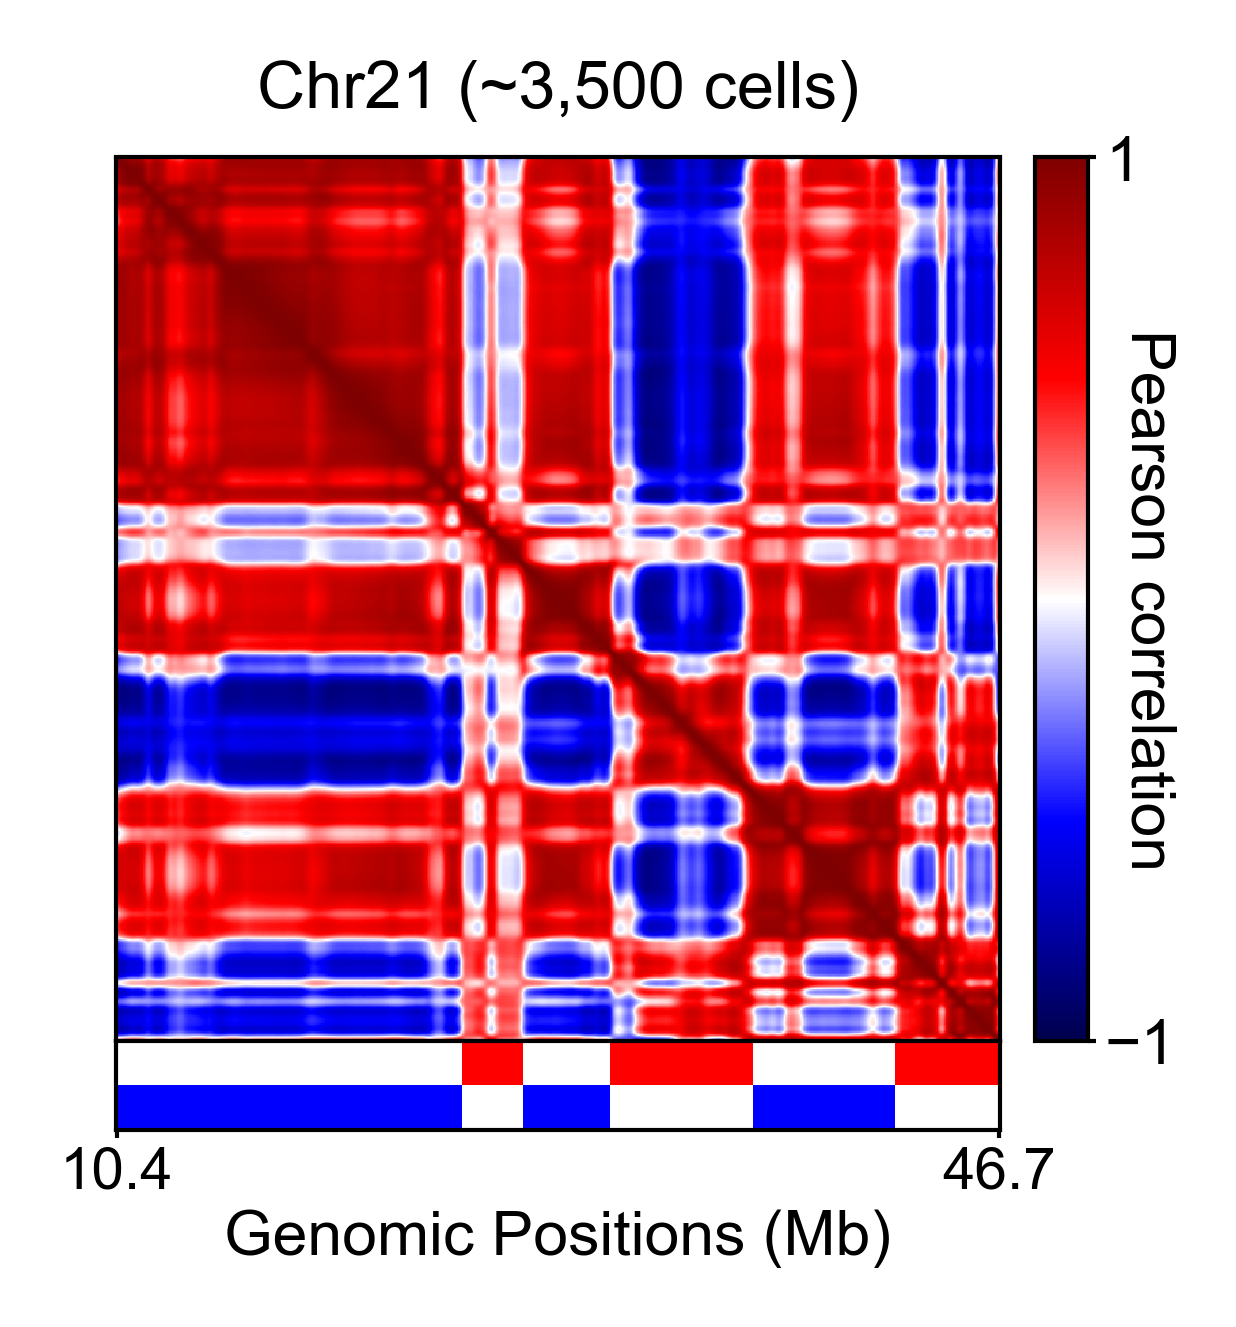

In [16]:
lims = [0,len(contact_corr_map_rep1)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(contact_corr_map_rep1, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep1['AB_dict']['A'], height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep1['AB_dict']['B'], height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])

_xticks = [0, len(contact_corr_map_rep1)-1]
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(np.round(mid_positions_Mb[_xticks],1))
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

# create left ax
#left_ax = divider.append_axes('left', size='10%', pad="0%", sharey=ax1, xticks=[])

#left_ax.barh(data_rep1['AB_dict']['A'], height=1, color='r', width=1, label='A')
#left_ax.barh(data_rep1['AB_dict']['B'], height=1, left=-1, color='b', width=1, label='B')

#left_ax.set_xticks([-0.5, 0.5])
#left_ax.set_xticklabels(['B', 'A'])

#_yticks = _xticks
#left_ax.set_yticks(_yticks)
#left_ax.set_yticklabels(mid_positions_Mb[_yticks])

#left_ax.tick_params('both', labelsize=_font_size-1, 
#                width=_ticklabel_width, length=_ticklabel_size-1,
#                pad=1, labelleft=True) # remove bottom ticklabels for ax1
#[i[1].set_linewidth(_ticklabel_width) for i in left_ax.spines.items()]
#
#left_ax.set_ylabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

# set limits
bot_ax.set_xlim(xlims-0.5)
#left_ax.set_ylim([max(ylims)-0.5, min(ylims)-0.5])

ax1.set_title(f"Chr21 (~3,500 cells)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2A_chr21_contact_corr_map_rep1.pdf'), transparent=True)

plt.show()

## FigS2A: plot PC1 for chr21 calling

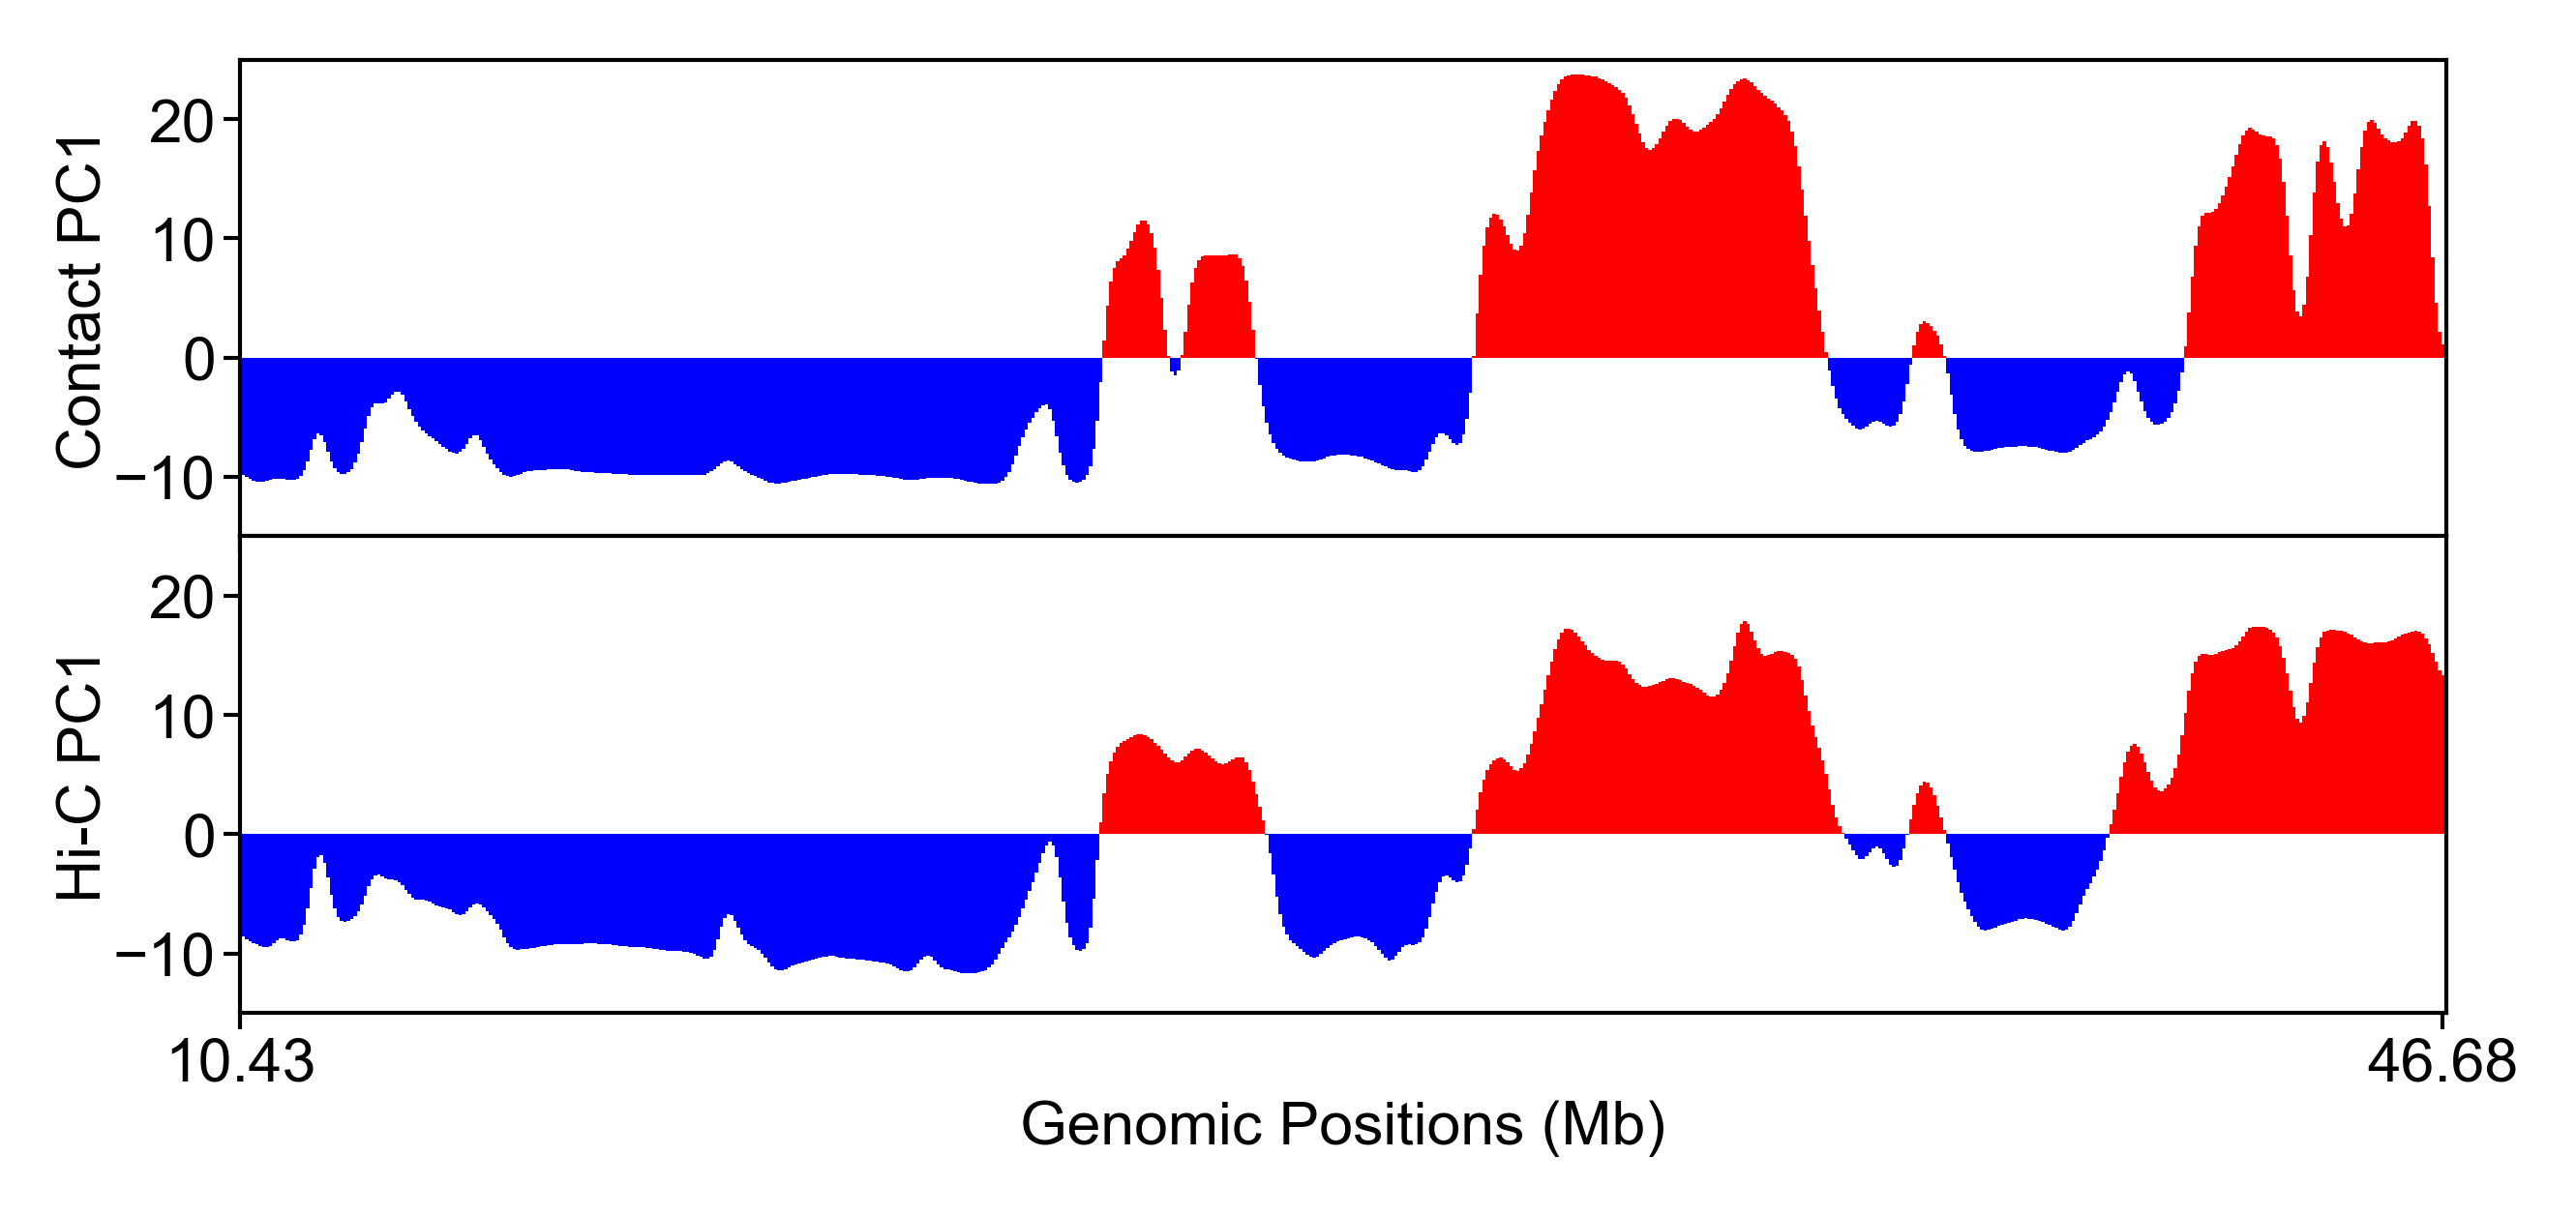

In [17]:
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(contact_pc1_rep1>=0)[0],
               contact_pc1_rep1[contact_pc1_rep1>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(contact_pc1_rep1<0)[0],
               contact_pc1_rep1[contact_pc1_rep1<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-15,25])
contact_ax.set_yticks([-10,0,10,20])
contact_ax.set_ylabel("Contact PC1", fontsize=_font_size, labelpad=0)


# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(hic_pc1>=0)[0],
               hic_pc1[hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(hic_pc1<0)[0],
               hic_pc1[hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
hic_ax.set_ylim([-15,25])
hic_ax.set_yticks([-10,0,10,20])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(contact_pc1_rep1)])
_xticks = [0, len(contact_pc1_rep1)-1]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(mid_positions_Mb[_xticks])
hic_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2A_chr21_PC1_barplot_rep1.pdf'), transparent=True)

plt.show()

### 0.1.3 density scores

In [18]:
import multiprocessing as mp
num_threads=32
density_var = 108 # nm

# density score for 50kb genomic regions
_dna_density_args = [(_zxys,_zxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _zxys in data_rep1['dna_zxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep1['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

# density score for tss
_gene_density_args = [(_gzxys,_zxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _gzxys, _zxys in zip(data_rep1['tss_zxys'], data_rep1['dna_zxys']) ]
_gene_density_time = time.time()

print(f"Multiprocessing calculate gene_density_scores", end=' ')
if 'gene_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as gene_density_pool:
        gene_density_dicts = gene_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _gene_density_args)
        gene_density_pool.close()
        gene_density_pool.join()
        gene_density_pool.terminate()
    # save
    data_rep1['gene_density_scores'] = gene_density_dicts
print(f"in {time.time()-_gene_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 54.721s.
Multiprocessing calculate gene_density_scores in 11.323s.


## FigS2C: mean density for chr21

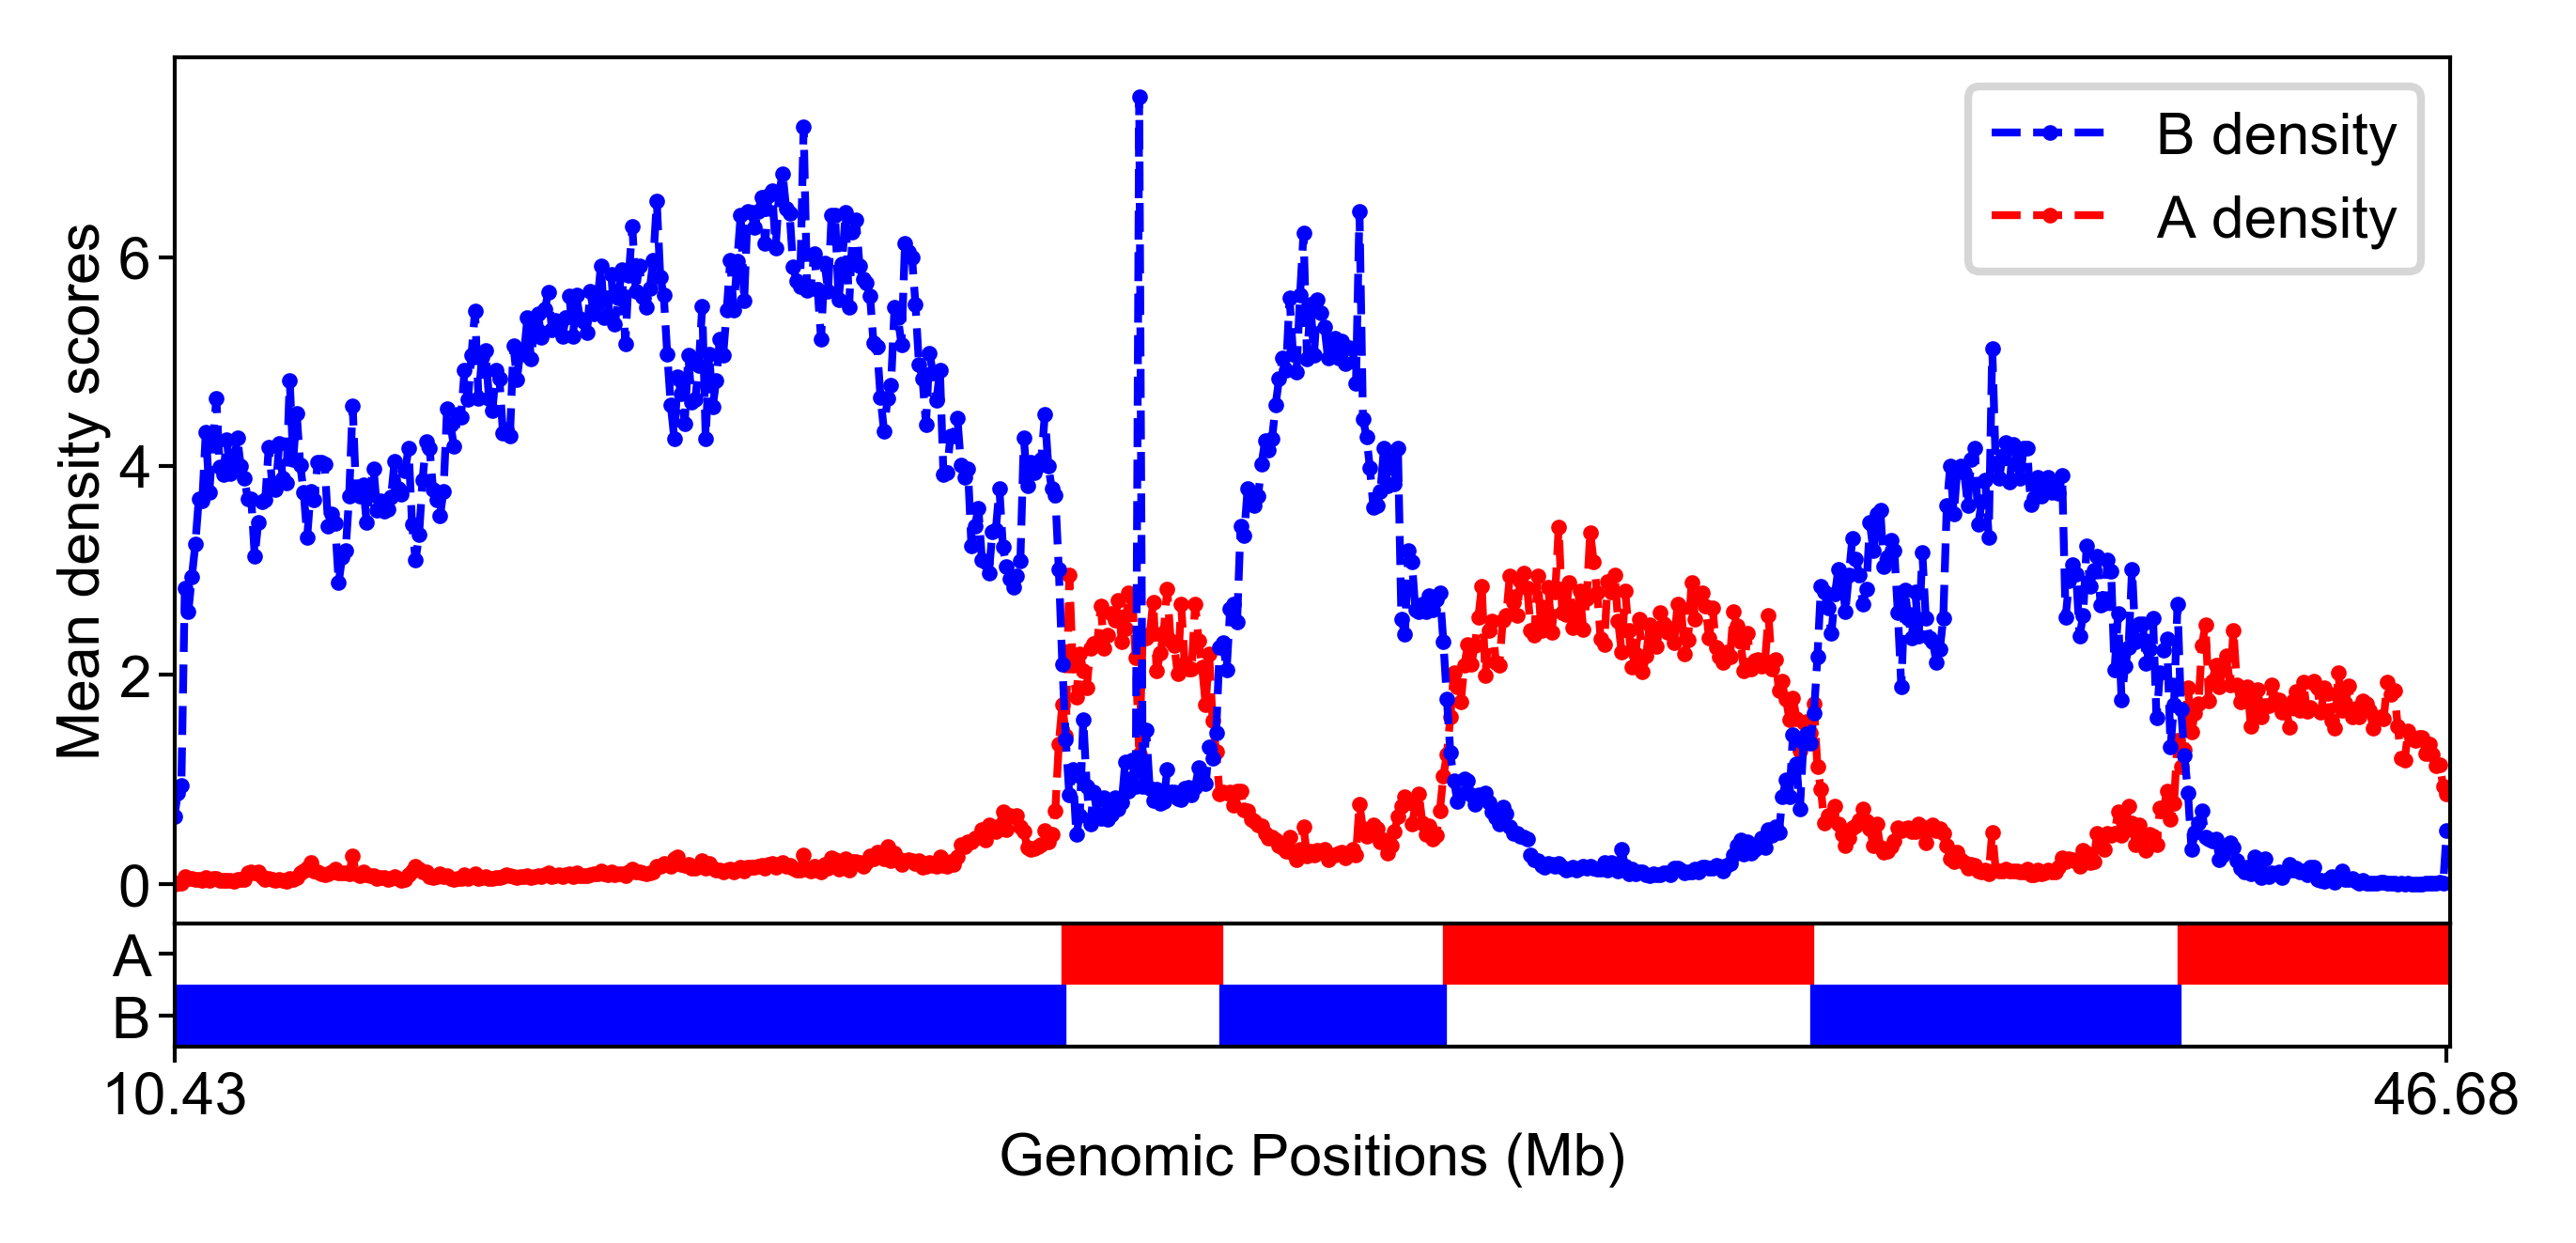

In [20]:
# Calculate mean A, B density
mean_A_scores = np.nanmedian([_s['A'] for _s in data_rep1['dna_density_scores']], axis=0)
mean_B_scores = np.nanmedian([_s['B'] for _s in data_rep1['dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(mean_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(mean_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Mean density scores", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(mean_A_scores))

comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_rep1['AB_dict']['A'], data_rep1['AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=1, 
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
_xticks = [0, len(mean_A_scores)-1]
comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(mid_positions_Mb[_xticks])
comp_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2C_chr21_mean_AB_density_rep1.pdf'), transparent=True)

plt.show()

### 0.1.4 segregation scores

In [21]:
def randomize_AB_dict(AB_dict):
    all_regs = np.sort(np.concatenate(list(AB_dict.values())))
    AB_identities = np.zeros(len(all_regs))
    AB_identities[np.array([_i for _i,_r in enumerate(all_regs) 
                            if _r in AB_dict['A']])] = 1
    # randomize new start
    new_start = np.random.randint(0, len(all_regs))
    new_AB_identities = np.concatenate([AB_identities[new_start:], AB_identities[:new_start]])
    # recreate AB_dict
    new_AB_dict = {'A': np.sort(all_regs[np.where(new_AB_identities==1)[0]]),
                   'B': np.sort(all_regs[np.where(new_AB_identities==0)[0]]),}
    return new_AB_dict

# calculate dynamic fraction scores
from scipy.stats import scoreatpercentile

In [22]:
AB_identities_rep1 = np.ones(len(data_rep1['dna_zxys'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

from tqdm import tqdm
# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep1['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep1['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep1['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep1['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep1['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep1 vector for purity calculation
    _rand_AB_identities_rep1 = np.ones(len(data_rep1['dna_zxys'][0])) * np.nan
    _rand_AB_identities_rep1[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep1[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep1['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep1['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

  0%|                                                                                         | 0/7591 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
 16%|███████████▉                                                                | 1192/7591 [00:00<00:01, 5916.89it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
  0%|                                                                                         | 0/7591 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\

## Fig 2C: segregation score histogram for Chr21

E:\Users\puzheng\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
E:\Users\puzheng\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


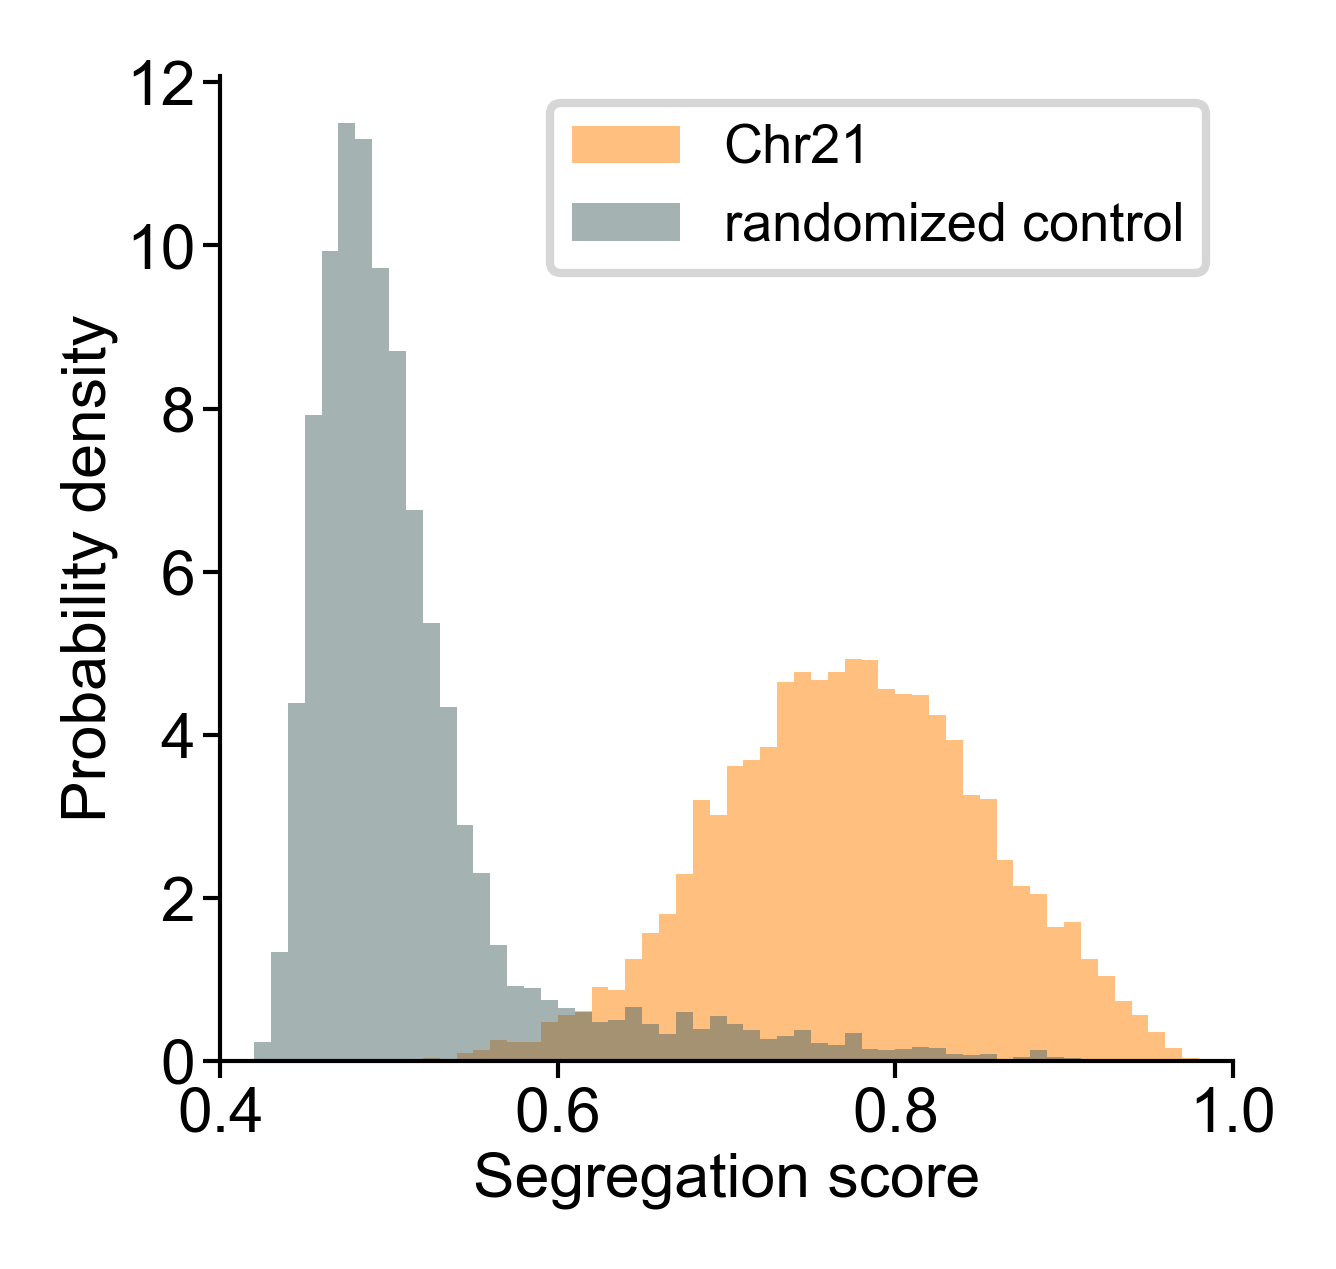

In [23]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_rep1['segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr21')
ax.hist(data_rep1['randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2C_chr21_segregation_hist_rep1.pdf'), transparent=True)
plt.show()

## Figure 2H: A/B density ratio difference w/wo transcription

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


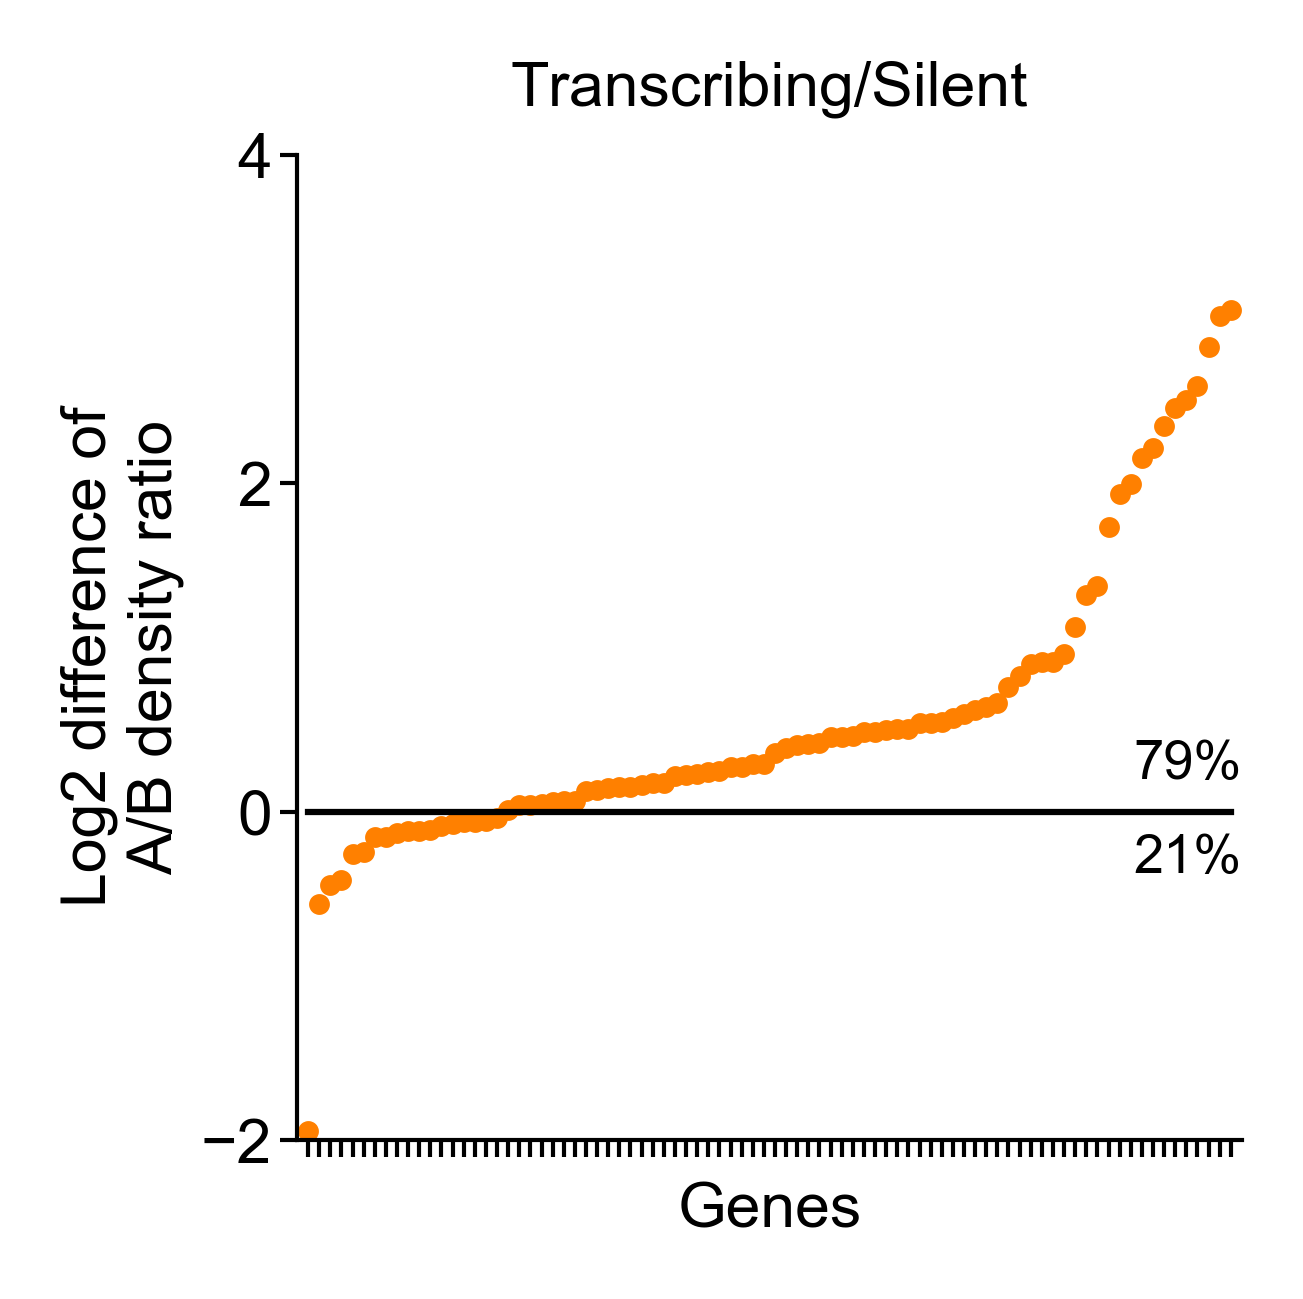

In [24]:
gene_density_dicts = data_rep1['gene_density_scores']
gene_A_scores = np.array([_gsd['A'] for _gsd in gene_density_dicts])
gene_B_scores = np.array([_gsd['B'] for _gsd in gene_density_dicts])

trans_pfs = np.array(data_rep1['trans_pfs'])

on_gene_AB_ratio, off_gene_AB_ratio = [], []
on_gene_total_density = []
off_gene_total_density = []

for _gind in range(gene_A_scores.shape[1]):
    # extract AB and transcription
    _a_scores = gene_A_scores[:, _gind]
    _b_scores = gene_B_scores[:, _gind]
    _transcriptions = trans_pfs[:,_gind]
    # get AB ratio
    _log_ab_ratios = np.log(_a_scores)/np.log(2) - np.log(_b_scores)/np.log(2)
    _total_density =  _a_scores+_b_scores
    # append
    on_gene_AB_ratio.append(np.nanmedian(_log_ab_ratios[_transcriptions & (np.isinf(_log_ab_ratios)==False)]))
    off_gene_AB_ratio.append(np.nanmedian(_log_ab_ratios[~_transcriptions & (np.isinf(_log_ab_ratios)==False)]))
    on_gene_total_density.append(np.nanmedian(_total_density[_transcriptions & (np.isinf(_total_density)==False)]))
    off_gene_total_density.append(np.nanmedian(_total_density[~_transcriptions & (np.isinf(_total_density)==False)]))


# convert into arrays
on_gene_AB_ratio = np.array(on_gene_AB_ratio)
off_gene_AB_ratio = np.array(off_gene_AB_ratio)
on_gene_total_density = np.array(on_gene_total_density)
off_gene_total_density = np.array(off_gene_total_density)

gene_ratio_diff = on_gene_AB_ratio - off_gene_AB_ratio

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.plot(np.sort(gene_ratio_diff), '.', color=[1,0.5,0], label='All genes', markersize=3)
ax.plot(np.zeros(len(gene_ratio_diff)), 'black', label='ref', linewidth=0.75)

ax.tick_params('both', labelsize=_font_size, width=_ticklabel_width, length=_ticklabel_size, pad=1) 
        
        # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks(np.arange(len(gene_ratio_diff)))
ax.set_yticks(np.arange(-6,6,2))
ax.set_xticklabels([])
ax.set_xlabel('Genes', fontsize=_font_size, labelpad=2)
ax.set_ylabel('Log2 difference of \nA/B density ratio', fontsize=_font_size, labelpad=2)
ax.set_xlim([-1, len(gene_ratio_diff)])
ax.set_ylim([-2,4])

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')
ax.text(len(gene_ratio_diff), max(ax.get_ylim())/30, f'{np.round(np.mean(gene_ratio_diff>0),2)*100:.0f}%', 
        fontsize=_font_size-1, verticalalignment='bottom', horizontalalignment='right',)
ax.text(len(gene_ratio_diff), -max(ax.get_ylim())/30, f'{np.round(np.mean(gene_ratio_diff<0),2)*100:.0f}%', 
        fontsize=_font_size-1, verticalalignment='top', horizontalalignment='right',)

ax.set_title("Transcribing/Silent", fontsize=_font_size)
plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, 'Fig2H_diff_abratio_w-wo_transcribe_rep1.pdf'), transparent=True)

plt.show()

## Figure 2I: firing rate difference with high/low A/B density ratio

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in true_divide
  if sys.path[0] == '':


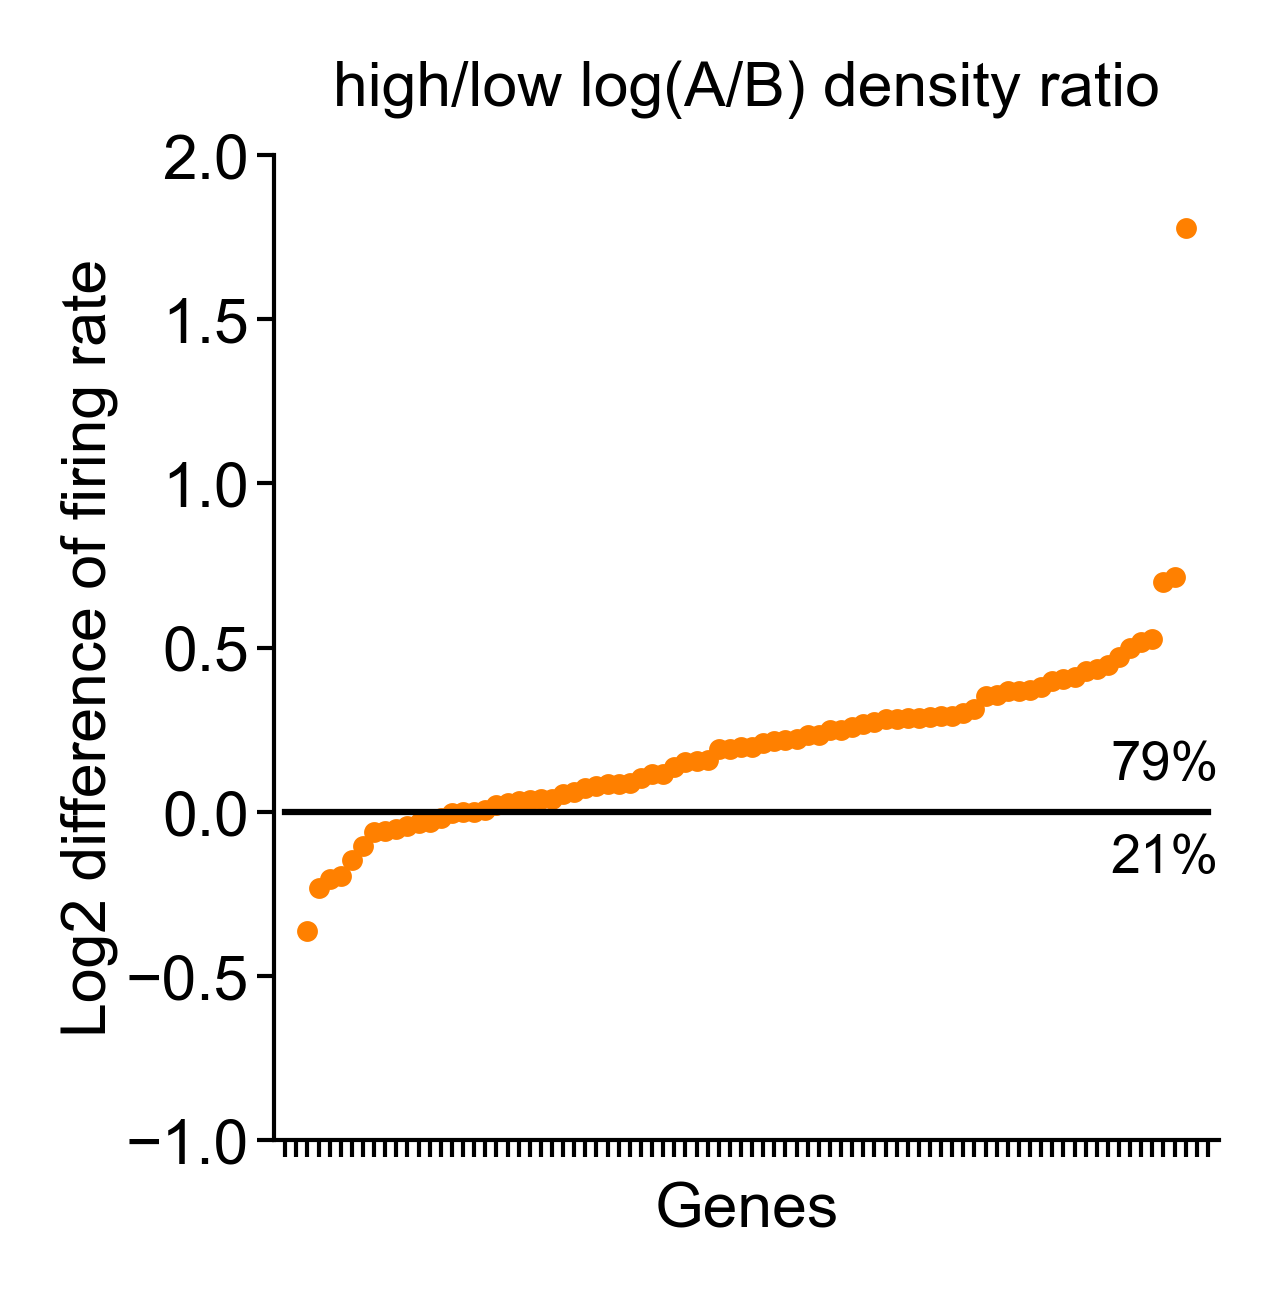

In [25]:
gene_density_dicts = data_rep1['gene_density_scores']
gene_A_scores = np.array([_gsd['A'] for _gsd in gene_density_dicts])
gene_B_scores = np.array([_gsd['B'] for _gsd in gene_density_dicts])

trans_pfs = np.array(data_rep1['trans_pfs'])

abratio_ratio = []
for _gid in np.arange(trans_pfs.shape[1]):
    # extract info
    _ga = gene_A_scores[:,_gid]
    _gb = gene_B_scores[:,_gid]
    _gratio = np.log(_ga / _gb) 
    
    # sel_inds
    _inds = np.argsort(_gratio)
    _sel_v = np.where((np.isnan(_gratio)==False) * (np.isinf(_gratio)==False))[0]
    _sel_inds = np.array([_i for _i in _inds if _i in _sel_v], dtype=np.int)
    
    _li = _sel_inds[:int(len(_sel_inds)/4)]
    _hi = _sel_inds[-int(len(_sel_inds)/4):]
    #print(len(_sel_inds), np.mean(_gratio[_li]), np.mean(_gratio[_hi]))
    _lfr = np.nanmean(trans_pfs[_li, _gid])
    _hfr = np.nanmean(trans_pfs[_hi, _gid])
    abratio_ratio.append(_hfr / _lfr)

abratio_fr_ratio = np.log(np.array(abratio_ratio)) / np.log(2)

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

#ax.plot(np.arange(len(sel_A_gene_inds)), 
#        np.sort(np.log(abratio_ratio[sel_A_gene_inds])), 
#        'r.', label='A genes', markersize=3)
#ax.plot(np.arange(len(sel_A_gene_inds),len(sel_A_gene_inds)+len(sel_B_gene_inds)), 
#         np.sort(np.log(abratio_ratio[sel_B_gene_inds])), 
#        'b.', label='B genes', markersize=3)

ax.plot(np.sort(abratio_fr_ratio), 
        '.', color=[1,0.5,0], label='All genes', markersize=3)
ax.plot(np.zeros(len(abratio_fr_ratio)), 
        'black', label='reference', linewidth=0.75)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
ax.set_xticks(np.arange(len(abratio_fr_ratio)))
ax.set_xticklabels([])
ax.set_ylabel('Log odds ratio', fontsize=_font_size, labelpad=1)
ax.set_xlim([-1, len(abratio_fr_ratio)])
ax.set_ylim([-1,2])

[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Genes', fontsize=_font_size, labelpad=2)
ax.set_ylabel('Log2 difference of firing rate', fontsize=_font_size, labelpad=1)
ax.set_title(f"high/low log(A/B) density ratio", 
             fontsize=_font_size)

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')

ax.text(len(abratio_fr_ratio), max(ax.get_ylim())/30, f'{np.round(np.mean(abratio_fr_ratio>0),2)*100:.0f}%', 
        fontsize=_font_size-1, verticalalignment='bottom', horizontalalignment='right',)
ax.text(len(abratio_fr_ratio), -max(ax.get_ylim())/30, f'{np.round(np.mean(abratio_fr_ratio<=0),2)*100:.0f}%', 
        fontsize=_font_size-1, verticalalignment='top', horizontalalignment='right',)

plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, f"Fig2I_firing-rate_diff_w_high-low_abratio_rep1.pdf"), transparent=True)

plt.show()